In [4]:
import ipywidgets as widgets
import matplotlib.pyplot as plt
import numpy as np
from scipy import integrate

import models
import payoffs
import plotting
import selection_functions

In [5]:
%matplotlib inline
plt.style.use("ggplot")

# Basic simulation

In [72]:
integrate.solve_ivp?

In [3]:
# random initial condition
prng = np.random.RandomState(42)
number_of_genotypes = 4
initial_offspring_share, = prng.dirichlet(np.ones(number_of_genotypes), 1)
y0 = initial_offspring_share

# define the selection functions
d1, d3 = 2, 1
UGA = lambda x_A: 1
UgA = lambda x_A: selection_functions.kirkpatrick_selection(x_A, d3)

# define the payoffs, metabolic costs and mutation rate
payoffs.prisoners_dilemma_payoffs(prng)
M, m = 0.0, 0.0
metabolic_costs = np.array([M, m])
mutation_rate = 0.0

In [4]:
payoff_kernel

NameError: name 'payoff_kernel' is not defined

In [5]:
solution = integrate.solve_ivp(F, t_span=(0, 100), y0=y0, method="RK45", rtol=1e-12, atol=1e-15,
                               dense_output=True, vectorized=True)

NameError: name 'F' is not defined

In [15]:
solution

  message: 'The solver successfully reached the interval end.'
     nfev: 4484
     njev: 0
      nlu: 0
      sol: <scipy.integrate._ivp.common.OdeSolution object at 0x112ca6128>
   status: 0
  success: True
        t: array([  0.00000000e+00,   1.52193394e-03,   1.67412733e-02,
         3.24649882e-02,   4.84517433e-02,   6.47040962e-02,
         8.12228973e-02,   9.80088474e-02,   1.15062476e-01,
         1.32384133e-01,   1.49973971e-01,   1.67831921e-01,
         1.85957699e-01,   2.04350784e-01,   2.23010416e-01,
         2.41935592e-01,   2.61125049e-01,   2.80577279e-01,
         3.00290524e-01,   3.20262778e-01,   3.40491800e-01,
         3.60975121e-01,   3.81710055e-01,   4.02693714e-01,
         4.23923025e-01,   4.45394754e-01,   4.67105518e-01,
         4.89051811e-01,   5.11230023e-01,   5.33636461e-01,
         5.56267375e-01,   5.79118973e-01,   6.02187443e-01,
         6.25468971e-01,   6.48959763e-01,   6.72656050e-01,
         6.96554116e-01,   7.20650296e-01,   7.4

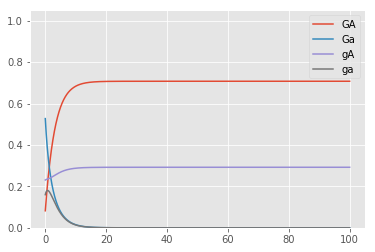

In [16]:
plt.plot(solution.t, solution.y[0], label="GA")
plt.plot(solution.t, solution.y[1], label="Ga")
plt.plot(solution.t, solution.y[2], label="gA")
plt.plot(solution.t, solution.y[3], label="ga")
plt.ylim(0, 1.05)
plt.legend()
plt.show()

# Interactive simulation

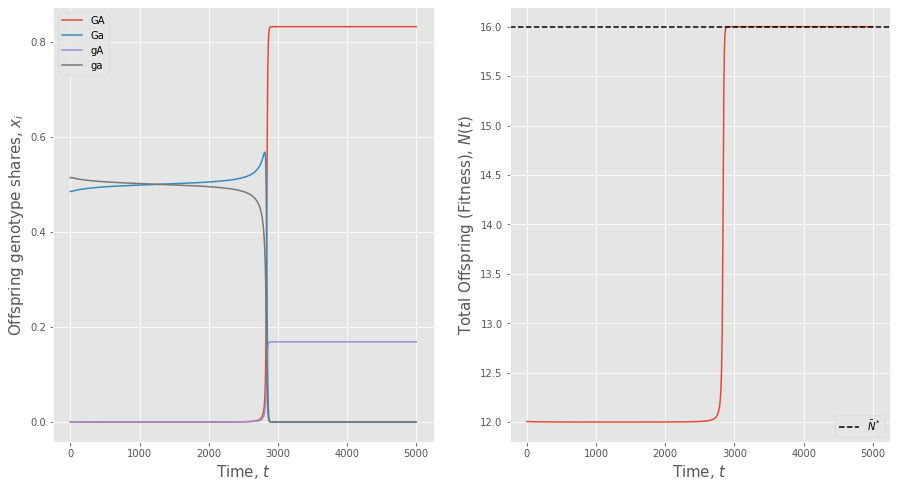

In [82]:
# sliders used to control the initial condition
x1_slider = widgets.FloatSlider(value=0.0, min=0.0, max=1.0, step=1e-3, description=r"$x_1$", readout_format=".3f")
x2_slider = widgets.FloatSlider(value=0.485, min=0.0, max=1.0, step=1e-3, description=r"$x_2$", readout_format=".3f")
x3_slider = widgets.FloatSlider(value=0.001, min=0.0, max=1.0, step=1e-3, description=r"$x_3$", readout_format=".3f")

# sliders used to control the Prisoner's Dilemma Payoffs
T_slider = widgets.FloatSlider(value=10, min=0, max=100, step=0.1, description=r"$T$")
R_slider = widgets.FloatSlider(value=8, min=0, max=100, step=0.1, description=r"$R$")
P_slider = widgets.FloatSlider(value=6, min=0, max=100, step=0.1, description=r"$P$")
S_slider = widgets.FloatSlider(value=4, min=0, max=100, step=0.1, description=r"$S$")

# sliders used to control the metabolic costs
M_slider = widgets.FloatSlider(value=0, min=0, max=100, step=0.1, description=r"$M_G$")
m_slider = widgets.FloatSlider(value=0, min=0, max=100, step=0.1, description=r"$m_g$")

# slider used to control which selection function is being used
U_slider = widgets.Dropdown(options=["kirkpatrick", "seger", "wright"], index=0, description=r"$U_{\gamma(j)A}$")

# slider that controls the parameters of the selection function
d1_slider = widgets.FloatSlider(value=2, min=0.0, max=10, step=0.05, description=r"$d_1$")
d3_slider = widgets.FloatSlider(value=1, min=0.0, max=10, step=0.05, description=r"$d_3$")

# slider used to control the mutation rate
e_slider = widgets.FloatSlider(value=0.0, min=0.0, max=1.0, step=1e-3, description=r"$\epsilon$", readout_format=".3f")

# slider that controls max simulation time
max_time_slider = widgets.IntSlider(value=5000, min=1, max=100000, description=r"$\max t$")

# slider used to control which selection function is being used
U_slider = widgets.Dropdown(options=["kirkpatrick", "seger", "wright"], index=0, description=r"$U_{\gamma(j)A}$")


w = widgets.interactive(plotting.plot_generalized_sexual_selection, x1=x1_slider, x2=x2_slider, x3=x3_slider,
                        selection_function=U_slider, d1=d1_slider, d3=d3_slider, 
                        T=T_slider, R=R_slider, P=P_slider, S=S_slider,
                        M=M_slider, m=m_slider, epsilon=e_slider,
                        max_time=max_time_slider)
display(w)

In [59]:
3.5/5

0.7

In [55]:
# can get access to the solution!
(solution, optimize_result) = w.result

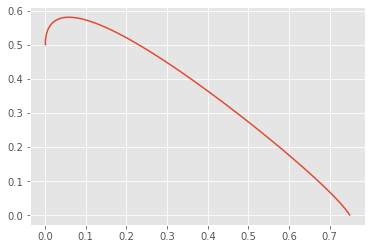

In [56]:
plt.plot(solution.y[0], solution.y[1])

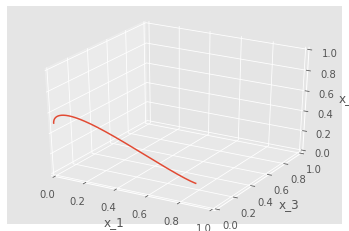

In [57]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.plot(solution.y[0], solution.y[2], solution.y[1])
ax.set_xlabel("x_1")
ax.set_ylabel("x_3")
ax.set_zlabel("x_2")
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
ax.set_zlim(0, 1)

plt.show()

In [45]:
solution.y.shape

(4, 788)